In [11]:
import CBB_Funcs as cbb_fun
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, classification_report, mean_absolute_error
import requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from playsound import playsound
import pickle

In [2]:
############# Loading in Data ################
## The process of scraping all the data from the web for all four years
## and performing 'combine_data' could take almost an hour

## By setting load = 'True', data is loaded from files that have
## already been processed. This can be done for all 4 years in about 15 seconds.

## By setting load = 'False', data can either be scraped from the web and then processed (scrape_data = 'True')
## or loaded from a file and then processed (scrape_data = 'False'). In the latter scenario, the processing consists of running
## the 'combine_data' function.

# Get team names and urls
teams_source = pd.read_excel('Team_Source.xlsx', header = None, names = ['2016', '2017', '2018', '2019', '2016_Teams', '2017_Teams', '2018_Teams', '2019_Teams'])

# select years to be processed
years = ['2016', '2017', '2018', '2019']

# Set data-gathering parameters
load = True
scrape_data = True

# Initialize dataframe
cbb_df = pd.DataFrame()

# loop through each year to be looked at
for yr in years:
    if load:
        sources, teams, team_dict = cbb_fun.get_logistics(teams_source, yr) # #urls and team names for that year
        #combined_df = [pd.read_csv('./Team_Dataframes/' + yr + '/Team_Combined/' + teams[ii] + '.csv') for ii in range(len(teams))] # load pre-processing data into list of dataframes   
#         with open('./Team_Dataframes/' + yr + '/Combined.pickle', 'rb') as f:
#             combined_df = pickle.load(f)
        combined_df = []
        for ii in range(len(teams)):
            with open('./Team_Dataframes/' + yr + '/Team_Combined/' + teams[ii] + '.pickle', 'rb') as f:
                combined_df.append(pickle.load(f))
        
        cbb_df = pd.concat((cbb_df, pd.concat(combined_df))) # concatenate all dataframes to final output dataframe
    else:
        teams_df, teams, team_dict = cbb_fun.get_team_data(teams_source, yr, scrape_data=scrape_data) # grab data for each team during the 'yr'
        combined_df, next_g = cbb_fun.combine_data(teams_df, team_dict, teams, year=yr) # process the data adding information about opponent and previous games
        cbb_df = pd.concat((cbb_df, pd.concat((combined_df)))) # concatenate all dataframes to final output dataframe

# if loading all years, save to final '.csv' file
# not necesasry for model development
if len(years) == 4:
    cbb_df.to_csv('./Final_Dataframes/Teams_Combined.csv', index=False)

print('DONE LOADING ALL DATA')
playsound('mixkit-intro-transition-1146.wav')

DONE LOADING ALL DATA


In [14]:
############# Sending Data to Predictive Models and Looking at Statistics################

# determine features to be sent into models
features = ['Avg_Result', 'Avg_Result2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS', 'SOS_NC', 'Opp_SOS_NC', 'Opp_Avg_FG_Pct', 'Opp_Avg_FG_Pct2', 'Pct_Margin', 'Pct_Margin2', 'Scoring_Pace_Diff']

# number of features
num_features = len(features)

#data = cbb_df.dropna(subset=features)
data = cbb_df[cbb_df['Game_Number'] > 9].dropna(subset=features)

data['Opp_Scoring_Pace_Diff'] = data['Scoring_Pace_Diff']*-1

opp_features = ['Avg_Result2', 'Avg_Result', 'Home2', 'Away2', 'Opp_SOS', 'SOS', 'Opp_Prev_SOS', 'Prev_SOS', 'Opp_SOS_NC', 'SOS_NC', 'Opp_Avg_FG_Pct2', 'Opp_Avg_FG_Pct', 'Pct_Margin2', 'Pct_Margin', 'Opp_Scoring_Pace_Diff']

X = data[list(set(features + opp_features))]
y = data['result'] # points spread
y2 = data['Win'] # Win (1) or Loss (0) result

# Save Results
with open('y.pickle', 'wb') as f:
        pickle.dump(y, f)
with open('y2.pickle', 'wb') as f:
        pickle.dump(y2, f)

# Null statistics if winner was chosen at random and points spread was predicted to be 0
print('NULL STATISTICS')
print('Standard Error:', np.std(y) / np.sqrt(len(y)))
print('Standard Deviation:', np.std(y))
print('Mean-squared Error:', mean_squared_error(y, [0]*len(y)))
print('Percent Win/Loss Prediction: 50 %')

# Winner always chosen to be home team - 50/50 for neutral-site games
print('\n\nHOME NULL CORRECT PREDICTIONS: ', cbb_fun.home_null(cbb_df[['Away', 'Win']]), '%')

# Send data to Linear Regression model and get statistics (increase n_runs for stability in results - ~20 sec per 100 runs)
SE, STD, MSE, CV, model, pct_acc, avg_lin_coefs, lin_lr =  cbb_fun.get_linear_stats(X, y, features, opp_features, n_runs=500)

# Save Average Linear MSE
with open('lin_mse.pickle', 'wb') as f:
        pickle.dump(MSE, f)

print('\n\nLINEAR STATISTICS')
print('Standard Error:', SE)
print('Standard Deviation:', STD)
print('Mean-squared Error:', MSE)
print('Percent Win/Loss Prediction: ', pct_acc, '%')
print('Cross-validation score:', CV)
print(model.summary())

best_fits1 = X[features].dot(avg_lin_coefs)
best_fits2 = -1 * (X[opp_features].dot(avg_lin_coefs))
best_fits = (best_fits1 + best_fits2) / 2

# Save Best fits
with open('best_fits.pickle', 'wb') as f:
        pickle.dump(best_fits, f)

# Difference between predicted results and test data
resid = best_fits - y

# Append statistics
print('Best fit SE:', np.std(resid, ddof=num_features) / np.sqrt(np.size(resid)))
print('Best fit STD:', np.std(resid, ddof=num_features))
print('Best fit MSE:', mean_squared_error(y, best_fits))

# Linear Best Fits
data['Lin_ypred'] = best_fits

# Send data to Logistic Regression model and get statistics (increase n_runs for stability in results - ~30 sec per 100 runs)
score, avg_log_coefs, log_lr, sc = cbb_fun.get_logistic_stats(X, y2, features, opp_features, n_runs=100)

print('\n\nLOGISITC STATISTICS')
print('Score: ', score, '%')
print('Average Coefficients:', avg_log_coefs)
logs = log_lr.predict(sc.transform(X[features]))
print('Classification Report\n', classification_report(y2, logs))

# # Grab logistic regression coefficients
# with open('log_reg_coef.pickle', 'rb') as f:
#     log_reg_coef = pickle.load(f)

# Log Best Fits
log_best_fit_preds, log_best_fit_probs = cbb_fun.log_best_fit(X[features], X[opp_features], sc, avg_log_coefs)
# log_best_fits1 = X[features].dot(avg_lin_coefs)
# log_best_fits2 = -1 * (X[opp_features].dot(avg_lin_coefs))
# log_best_fits = (best_fits1 + best_fits2) / 2

# Add Logistic Regression Predictions to Dataframe
data['Log_y2pred'] = log_best_fit_preds
data['Log_y2prob'] = log_best_fit_probs

# Send Data to RandomForest models and get statistics
# This does Regression for the points spread and Classification for the Win/Loss result
# Default hyperparameters were selected using results from GridSearchCV tuning 
rf_mse, rf_acc, rf_reg, rf_class, rf_y_pred, rf_y2_pred = cbb_fun.get_rf_stats(X, y, y2, features, opp_features)

# Save RF Values
with open('rf_mse.pickle', 'wb') as f:
        pickle.dump(rf_mse, f)
with open('rf_class.pickle', 'wb') as f:
        pickle.dump(rf_class, f)
with open('rf_reg.pickle', 'wb') as f:
        pickle.dump(rf_reg, f)

# Add Linear Regression Predictions to Dataframe
data['RF_ypred'] = rf_y_pred
data['RF_y2pred'] = rf_y2_pred

print('\n\nRANDOM FOREST STATISTICS')
print('Points Spread MSE (Regressor):', rf_mse)
print('Percent Win/Loss Prediction (Classifier): ', rf_acc, '%')
print('Classification Report\n', classification_report(y2, rf_class.predict(X[features])))

# Combine Models
mse_av, acc_av, y_tests, y2_tests, y_preds, y2_preds, y2_probs, log_y2_prbs, rf_y2_probs = cbb_fun.combine_models(X, y, y2, features, opp_features, MSE, rf_mse, n_runs=10)

# Save Average MSE and Accuracy
with open('av_mse.pickle', 'wb') as f:
    pickle.dump(mse_av, f)
with open('acc_av.pickle', 'wb') as f:
    pickle.dump(acc_av, f)

print('\n\nModel Combination MSE:', mse_av)
print('Model Combination Accuracy:', acc_av)


## Create Confidence Distributions for Given Scores (ie. percent confidence above below a value)
val_range = np.linspace(-25, 25, 51)
prob_dists = cbb_fun.create_pts_spread_odds(y_preds, y_tests, val_range)
dist_models, xs = cbb_fun.create_models(val_range, prob_dists)

with open('prob_dists.pickle', 'wb') as f:
    pickle.dump(prob_dists, f)
with open('val_range.pickle', 'wb') as f:
    pickle.dump(val_range, f)
with open('dist_models.pickle', 'wb') as f:
    pickle.dump(dist_models, f)

        

# game_nums = list(range(10, 32))

# SEs = []
# STDs = []
# MSEs = []
# CVs = []
# pct_accs = []
# avg_lin_coefss = []




# for num in game_nums:
    
#     if num < 31:
#         X = data[data['Game_Number'] == num][features]
#         y = data[data['Game_Number'] == num]['result']
#     else:
#         X = data[data['Game_Number'] >= num][features]
#         y = data[data['Game_Number'] >= num]['result']
    
#     SE, STD, MSE, CV, model, pct_acc, avg_lin_coefs, lr = cbb_fun.get_linear_stats(X, y)
    
#     #print(num)
#     #print(model.summary())
    
#     SEs.append(SE)
#     STDs.append(STD)
#     MSEs.append(MSE)
#     CVs.append(CV)
#     pct_accs.append(pct_acc)
#     avg_lin_coefss.append(avg_lin_coefs)
    
# cbb_fun.plot_params(SEs, STDs, MSEs, CVs, pct_accs, avg_lin_coefss)
    
playsound('mixkit-intro-transition-1146.wav')

NULL STATISTICS
Standard Error: 0.07949575963209486
Standard Deviation: 14.160959687437149
Mean-squared Error: 200.55760746249842
Percent Win/Loss Prediction: 50 %


HOME NULL CORRECT PREDICTIONS:  63.378092191231474 %


LINEAR STATISTICS
Standard Error: 0.12458377098593905
Standard Deviation: 11.096351345062898
Mean-squared Error: 122.91474692336983
Percent Win/Loss Prediction:  71.650523131224 %
Cross-validation score: 0.38724632750463167
                                 OLS Regression Results                                
Dep. Variable:                 result   R-squared (uncentered):                   0.387
Model:                            OLS   Adj. R-squared (uncentered):              0.387
Method:                 Least Squares   F-statistic:                              1003.
Date:                Wed, 03 Mar 2021   Prob (F-statistic):                        0.00
Time:                        12:53:59   Log-Likelihood:                         -90986.
No. Observations:          

In [4]:
################ Make Predictions ##################
matchups = [['Duke', 'Michigan State', 2],
            ['Florida', 'Florida State', 0],
            ['Michigan', 'Ohio State', 2]]


with open('next_g_2019.pickle', 'rb') as f:
    next_g = pickle.load(f)

print('BEGINNING MATCHUP CREATION')
    
next_g = cbb_fun.get_next_games(next_g, combined_df, team_dict)

matchup_vals = cbb_fun.create_matchups(matchups, next_g, team_dict)

print('ENDING MATCHUP CREATION')

with open('log_reg_coef.pickle', 'rb') as f:
    log_reg_coef = pickle.load(f)
    
with open('log_reg_sc.pickle', 'rb') as f:
    sc = pickle.load(f)

with open('lin_reg_coef.pickle', 'rb') as f:
    lin_reg_coef = pickle.load(f)
    
with open('rf_mse.pickle', 'rb') as f:
    rf_mse = pickle.load(f)

with open('lin_mse.pickle', 'rb') as f:
    lin_mse = pickle.load(f)
    
with open('av_mse.pickle', 'rb') as f:
    av_mse = pickle.load(f)
    
with open('rf_class.pickle', 'rb') as f:
        rf_class = pickle.load(f)

with open('rf_reg.pickle', 'rb') as f:
        rf_reg = pickle.load(f)
        
with open('dist_models.pickle', 'rb') as f:
        dist_models = pickle.load(f)

# regr_models = [lin_lr, rf_reg]
# class_models = [log_lr, rf_class]



# cbb_fun.regr_predict(regr_models, matchup_vals, matchups)
# cbb_fun.class_predict(class_models, matchup_vals, sc, matchups)

lin_preds = cbb_fun.lin_regr_predict(lin_reg_coef, matchup_vals, matchups)
rf_reg_preds = cbb_fun.rf_regr_predict(rf_reg, matchup_vals, matchups)
log_reg_preds, log_reg_probs = cbb_fun.log_regr_predict(log_reg_coef, matchup_vals, sc, matchups)
rf_class_preds, rf_class_probs = cbb_fun.rf_class_predict(rf_class, matchup_vals, sc, matchups)

lin_weight = 1 - (lin_mse/ (lin_mse+rf_mse))
rf_regr_weight = 1 - (rf_mse / (lin_mse+rf_mse))

final_pts_spread = [(lin_weight * lin_pred) + (rf_regr_weight * rf_reg_pred[0]) for lin_pred, rf_reg_pred in zip(lin_preds, rf_reg_preds)]
final_probs = np.mean([log_reg_probs, rf_class_probs], axis=0)

np.set_printoptions(suppress=True)

for jj, spread in enumerate(final_pts_spread):

    confidence = cbb_fun.get_confidence(dist_models, spread, xs)
    print(matchups[jj][0], final_pts_spread[jj])
    print(pd.DataFrame(confidence))
    print('\n\n')
    
    confidence = cbb_fun.get_confidence(dist_models, -spread, xs)
    print(matchups[jj][1], -1* final_pts_spread[jj])
    print(pd.DataFrame(confidence))
    print('\n\n')
    
np.set_printoptions(suppress=False)

playsound('mixkit-intro-transition-1146.wav') 
final_pts_spread, final_probs

BEGINNING MATCHUP CREATION
ENDING MATCHUP CREATION
Linear Regression model points spread: Duke 3.4051 to Michigan State ((3.4090168906149714, 3.4011659073002))

Linear Regression model points spread: Florida -5.6851 to Florida State ((-5.75221359734774, -5.618037603960603))

Linear Regression model points spread: Michigan 6.9528 to Ohio State ((6.949575577782351, 6.955961367331064))

Random Forest model points spread: Duke 2.9736 to Michigan State ((array([3.0079006]), array([2.93927956])))

Random Forest model points spread: Florida -6.2175 to Florida State ((array([-6.34279897]), array([-6.09217267])))

Random Forest model points spread: Michigan 9.925 to Ohio State ((array([9.66496005]), array([10.18508334])))

Logistic Regression model prediction: Duke Win (62.6957% probability)

Logistic Regression model prediction: Florida Loss (28.7134% probability)

Logistic Regression model prediction: Michigan Win (76.2322% probability)

Random Forest Classification model prediction: Duke Win

([3.1931863038101405, -5.946561289755206, 8.412406205008491],
 array([0.59055829, 0.25632596, 0.77761   ]))

In [3]:
# X = data[features]
# y = data['result']

# lrs = []
# lrcvs = []
# rfs = []
# rfcvs = []

# for ii in range(100):
#     X_train, X_test, y_train, y_test = train_test_split(X, y)
#     lrcvs.append(cross_val_score(LinearRegression(fit_intercept=False), X, y, cv=KFold(10, shuffle=True), scoring='neg_mean_squared_error').mean())
#     rfcvs.append(cross_val_score(RandomForestRegressor(n_estimators=130, max_depth=9, max_features=9), X, y, cv=KFold(10, shuffle=True), scoring='neg_mean_squared_error').mean())
#     rfg = RandomForestRegressor(n_estimators=130, max_depth=9, max_features=9)
#     lr = LinearRegression(fit_intercept=False)
#     rfg.fit(X_train, y_train)
#     lr.fit(X_train, y_train)

#     y_pred = rfg.predict(X_test)
#     y_pred2 = lr.predict(X_test)
#     #print(mean_squared_error(y_pred, y_test), mean_squared_error(y_pred2, y_test))
#     lrs.append(mean_squared_error(y_pred2, y_test))
#     rfs.append(mean_squared_error(y_pred, y_test))
#     print(ii)
    
# print(np.mean(lrs), np.mean(lrcvs), np.mean(rfs), np.mean(rfcvs))
# playsound('mixkit-intro-transition-1146.wav')

lin_weight = 1 - (MSE/ (MSE+rf_mse))
rf_regr_weight = 1 - (rf_mse / (MSE+rf_mse))

final_pts_spread = [(lin_weight * lin_pred) + (rf_regr_weight * rf_reg_pred[0]) for lin_pred, rf_reg_pred in zip(lin_preds, rf_reg_preds)]
final_pts_spread

NameError: name 'MSE' is not defined

In [103]:

        
with open('log_reg_coef.pickle', 'wb') as f:
    pickle.dump(avg_log_coefs, f)
    
with open('log_reg_sc.pickle', 'wb') as f:
    pickle.dump(sc, f)

with open('log_reg_coef.pickle', 'rb') as f:
    log_reg_coef = pickle.load(f)
    
with open('log_reg_sc.pickle', 'rb') as f:
    sc = pickle.load(f)
    
# regr_models = [lin_lr, rf_reg]
# class_models = [log_lr, rf_class]

# cbb_fun.regr_predict(regr_models, matchup_vals, matchups)
# cbb_fun.class_predict(class_models, matchup_vals, sc, matchups)

# lin_preds = lin_regr_predict(lin_reg_coef, matchup_vals, matchups)
# rf_reg_preds = rf_regr_predict(rf_reg, matchup_vals, matchups)
# log_reg_preds, test3 = log_regr_predict(log_reg_coef, matchup_vals, sc, matchups)
# rf_class_preds, test4 = rf_class_predict(rf_class, matchup_vals, sc, matchups)

# log_reg_preds[:5], test3[:5], rf_class_preds[:5], test4[:5]
log_best_fits, test = log_best_fit(X[features], X[opp_features], sc, log_reg_coef)

log_best_fits[:5], test[:5]

([0, 1, 1, 0, 1],
 [0.39003229780710236,
  0.5057572276762478,
  0.7381674541311316,
  0.07917210032402774,
  0.631287472898042])

12.742967786634216


(8.712945193206522, 11.287813404964611, 11.27644018656246)

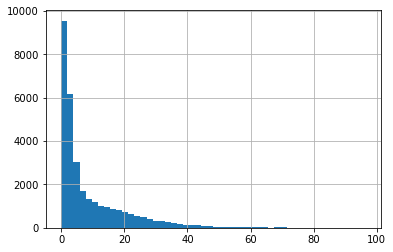

In [696]:
#mult = np.std(best_fits) / np.std(data['result'])
# mult = 0.7

# a = []

# for val in best_fits:
#     if val < -3.5:
#         a.append(val - (-3.5 - val)*mult)
#     elif val > 3.5:
#         a.append(val - (3.5 - val)*mult)
#     elif val > 0:
#         a.append(val + (3.5 - val)*(mult/2))
#     else:
#         a.append(val + (-3.5 - val)*(mult/2))
# # a = np.where(best_fits < 0, best_fits  + (-3 - best_fits)*mult, best_fits + (3 - best_fits)*mult)
# # a[:10], best_fits[:10]
# a = pd.Series(a)
# a.hist(bins=50)

#mult = np.std(best_fits) / np.std(data['result'])
mult = 0.7

a = []

for pred in best_fits:
    if pred < 0:
        a.append(pred - pred*4/3)
    else:
        a.append(pred + pred*4/3)
        
# a = np.where(best_fits < 0, best_fits  + (-3 - best_fits)*mult, best_fits + (3 - best_fits)*mult)
# a[:10], best_fits[:10]
a = pd.Series(a)
a.hist(bins=50);

print(mean_absolute_error(a, data['result']))
mean_absolute_error(best_fits, data['result']), (abs(best_fits ) + 4.5).mean(), abs(data['result']).mean()

In [8]:
X = data[features]
sc = StandardScaler()
Xsc = sc.fit_transform(X)
y2 = data['Win']

#accs = cross_val_score(RandomForestClassifier(n_estimators=134, max_depth=6, max_features=6), \
                                  #   Xsc, y2, cv=KFold(10, shuffle=True), scoring='accuracy').mean()
#np.mean([accs])

In [14]:
#(abs(a).sort_values() - abs(data['result']).sort_values())[:10]
# pd.Series(abs(a).sort_values().values - abs(data['result']).sort_values().values).plot()
#pd.Series(a.sort_values().values - data['result'].sort_values().values).plot()
#print(a.sort_values().values[:10])
Xsc.shape[1]

rf_class = RandomForestClassifier()
params = {'n_estimators': range(150, 251, 25), 'max_depth': range(3, Xsc.shape[1]), 'max_features': range(3, Xsc.shape[1])}
cvtree = GridSearchCV(rf_class, params)
cvtree.fit(Xsc, y2)
best_params = cvtree.best_params_
print(best_params)
# {'max_depth': 9, 'max_features': 8, 'n_estimators': 200} - 70.79916

{'max_depth': 9, 'max_features': 8, 'n_estimators': 200}


In [15]:
accs = cross_val_score(RandomForestClassifier(n_estimators=200, max_depth=9, max_features=8), \
                                     Xsc, y2, cv=KFold(10, shuffle=True), scoring='accuracy').mean()
accs

0.7079916080683126

2.0
4.0
4.904761904761912
6.0
7.0
1.5
4.0
4.0
5.0
5.5


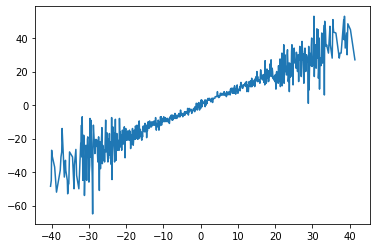

In [744]:
# b = pd.DataFrame(best_fits)
# c = pd.DataFrame(data['result'])

# d = pd.concat((b, c), axis=1)
# e = d.sort_values(by=['result'])

#plt.plot(e['result'], (e[0]-0.10859)* 1/0.3859)

# print(d[['result']].shape, d[0].shape)

# linreg = LinearRegression()
# linreg.fit(e[['result']], (e[0]-0.10859)* 1/0.3859)
# linreg.fit_intercept = False
# linreg.coef_, linreg.intercept_

# mean_squared_error((e[0]-0.10859)* 1/0.3859, e['result'])

# f = e[(e['result'] < 40) & (e['result'] > -40)].groupby('result').mean()
# #plt.plot(f.index, f[0])

# test = e[e['result'] == 3]
# print(e[e['result'] == 3])
# print(test[0].mean())
# print(mean_absolute_error(test[0]+1, test['result']))
# print(mean_absolute_error(data['result'], best_fits+0.1))
# mean_squared_error(test[0]+2, test['result'])

e = pd.DataFrame(np.round(best_fits, 1))
f = data['result']

g = pd.concat((e, f), axis=1)
h = g.groupby(0).median()
z = g.groupby(0).mean()
#plt.plot(h['result'], z['result']);

#h[:10], z[:10]

print(np.percentile(g[g[0] == 1]['result'], 100*110/210))#.hist(bins=20)
print(np.percentile(g[g[0] == 2]['result'], 100*110/210))
print(np.percentile(g[g[0] == 3]['result'], 100*110/210))
print(np.percentile(g[g[0] == 4]['result'], 100*110/210))
print(np.percentile(g[g[0] == 5]['result'], 100*110/210))

print(np.percentile(g[g[0] == 1]['result'], 50))#.hist(bins=20)
print(np.percentile(g[g[0] == 2]['result'], 50))
print(np.percentile(g[g[0] == 3]['result'], 50))
print(np.percentile(g[g[0] == 4]['result'], 50))
print(np.percentile(g[g[0] == 5]['result'], 50))

h[10:15]
plt.plot(h.index, h['result'])

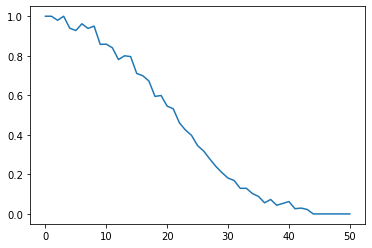

In [41]:
def create_pts_spread_odds(y_preds, y_tests, val_range):
    
    rounded_y_preds = pd.DataFrame(np.round(y_preds, 0), columns = ['y_pred'])
    y_tests = pd.DataFrame(y_tests, columns = ['y_test'])
    f = data['result']

    preds_and_results = pd.concat((rounded_y_preds, y_tests), axis=1)
    
    vals = np.round(val_range, 0)

    dicts = {val: [] for val in vals}

    for ii, result in enumerate(preds_and_results['y_test']):
        prediction = preds_and_results['y_pred'].iloc[ii]
        if prediction in val_range:
            dicts[prediction].append(result)

    #plt.hist(dicts[21], bins=20);

    prob_dists = []

    for jj in vals:

        probs = []

        for kk in vals:

            count = 0

            len_dict = len(dicts[kk])

            if len_dict > 0:
                for val in dicts[kk]:

                    if val < jj:
                        count += 1

                probs.append(count/len_dict)
        
        prob_dists.append(probs)
        
    return prob_dists

with open('best_fits.pickle', 'rb') as f:
    best_fits = pickle.load(f)
    
with open('y.pickle', 'rb') as f:
    y = pickle.load(f)

val_range = np.linspace(-25, 25, 51)
prob_dists = create_pts_spread_odds(y_preds, y_tests, val_range)
plt.plot(list(range(len(prob_dists[21]))), prob_dists[21]);

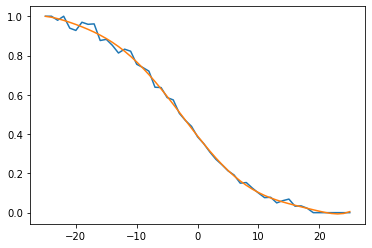

In [106]:
def create_models(val_range, prob_dists):
    xs = np.round(val_range, 0)
    models = []
    for x2 in xs:
        coefs_fit = np.polyfit(xs, prob_dists[int(x2)-int(xs[0])], 7)
        models.append(coefs_fit)
    
    return models, xs

dist_models, xs = create_models(val_range, prob_dists)

def get_confidence(models, prediction, xs):

    pcts = []

    for ii, model in enumerate(models):

        pct = 1 - (model[0]*(prediction**7) + model[1]*(prediction**6) + model[2]*(prediction**5) + model[3]*(prediction**4) + model[4]*(prediction**3) + model[5]*(prediction**2) + model[6]*prediction + model[7])

        if pct > 0.5:
            odds = -(100*pct)/(1-pct)
        else:
            odds = (100/pct) - 100

        pcts.append((pct, ii+xs[0], odds))
#         d = []
#         for x in xs:

#             d.append(model[0]*(x**7) + model[1]*(x**6) + model[2]*(x**5) + model[3]*(x**4) + model[4]*(x**3) + model[5]*(x**2) + model[6]*x + model[7])

#         models.append(d)
#     plt.plot(xs, prob_dists[10])
#     plt.plot(xs, d);
    
    return pcts

d = []
num = 22
for x in xs:
    
    d.append(dist_models[num][0]*(x**7) + dist_models[num][1]*(x**6) + dist_models[num][2]*(x**5) + dist_models[num][3]*(x**4) + dist_models[num][4]*(x**3) + dist_models[num][5]*(x**2) + dist_models[num][6]*x + dist_models[num][7])

#models.append(d)
plt.plot(xs, prob_dists[num])
plt.plot(xs, d);

prediction = 15

#confidence = get_confidence(models, prediction, xs)

#np.set_printoptions(suppress=True)
#confidence[:5], np.array(confidence)[:5, :]
#np.set_printoptions(suppress=False)

In [68]:
max(xs[0], x2-10), xs[0], x2, xs

(20.0,
 -25.0,
 30.0,
 array([-25., -24., -23., -22., -21., -20., -19., -18., -17., -16., -15.,
        -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
         -3.,  -2.,  -1.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
          8.,   9.,  10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,
         19.,  20.,  21.,  22.,  23.,  24.,  25.]))

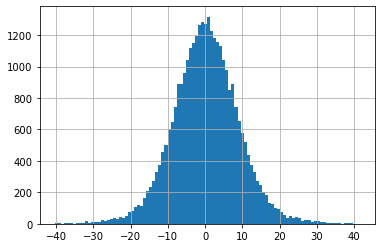

In [517]:
best_fits.hist(bins=100);

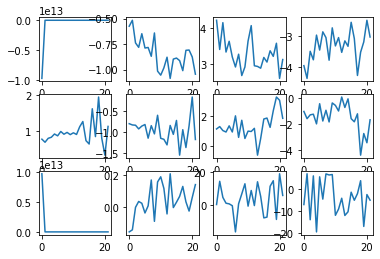

In [319]:
for ii in range(len(avg_lin_coefss[0])):
    pts = []
    for num in avg_lin_coefss:
        pts.append(num[ii])
    plt.subplot(3, 4, ii+1).plot(list(range(22)), pts)

#plt.subplot(2,5,1).plot(list(range(len(SEs))), SEs)

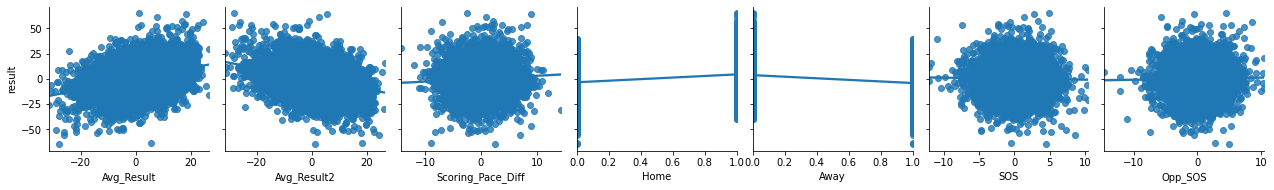

In [637]:
#sns.residplot(X, y);
sns.pairplot(pd.concat((X, y), axis = 1), x_vars=['Avg_Result', 'Avg_Result2', 'Scoring_Pace_Diff', 'Home', 'Away', 'SOS', 'Opp_SOS'], y_vars='result', kind='reg');

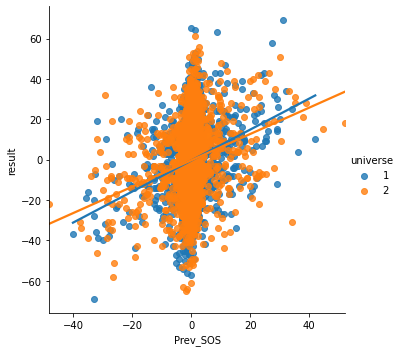

In [45]:
X['universe'] = np.random.randint(1, 3, len(X))

sns.lmplot(x = 'Prev_SOS', y='result', hue='universe', data=pd.concat((X, y), axis = 1), ci=False);

In [127]:
## Square the x-variables to represent
X2s = pd.concat((X, X[['SOS_NC', 'Opp_SOS_NC']] ** 3), axis = 1)

## Split the data up into train and test values
X2_train, X2_test, y2_train, y2_test = train_test_split(X2s, y)

## Create Linear Regression model
lr.fit_intercept = False
lr = LinearRegression()
lr.fit(X2_train, y2_train)

## Calculate scores of new model on training data (MSE and R^2)
y2_pred_train = lr.predict(X2_train)
print('Train MSE:', mean_squared_error(y2_train, y2_pred_train))
print('Train Score:', lr.score(X2_train, y2_train))

## Calculate scores of new model on test data (MSE and R^2)
y2_pred_test = lr.predict(X2_test)
print('Test MSE:', mean_squared_error(y2_test, y2_pred_test))
print('Test Score:', lr.score(X2_test, y2_test))

MSEs = []
SE = []
stds = []
scores = []
    
for ii in range(100):
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2s, y)

    lr.fit_intercept = False
    lr.fit(X2_train, y2_train)
    #print('Coefficients:',lr.coef_)

    y2_pred = lr.predict(X2_test)

    resid = y2_pred - y2_test
    
    SE.append(np.std(resid, ddof=len(features) + 2) / np.sqrt(np.size(resid)))
    stds.append(np.std(resid, ddof=len(features) + 2))
    MSEs.append(mean_squared_error(y2_test, y2_pred))
    scores.append(lr.score(X2_test, y2_test))

print('Standard Error:', np.mean(SE))
print('Standard Deviation (ddof)', np.mean(stds))
#print('Standard Deviation', np.std(resid))
print('MSE:', np.mean(MSEs))
print('Scores:', np.mean(scores))

Train MSE: 137.03144618816856
Train Score: 0.4111866244760036
Test MSE: 130.55324734371004
Test Score: 0.3922299330320854
Standard Error: 0.23534309139952161
Standard Deviation (ddof) 11.665518108293398
MSE: 135.6815210132989
Scores: 0.4027128331961932


Standard Error: 0.23724525028148086
Standard Deviation 11.759804576404234
Standard Deviation 11.743040769483436


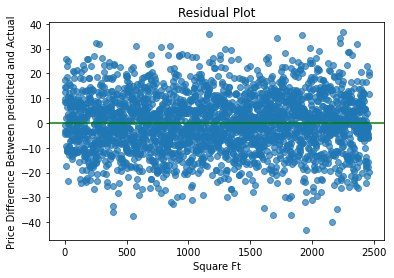

In [83]:
y_pred = lr.predict(X_test)

resid = y_pred - y_test

plt.scatter(list(range(len(resid))), resid, alpha = 0.7);
plt.title('Residual Plot')
plt.xlabel('Square Ft')
plt.ylabel('Price Difference Between predicted and Actual')
plt.axhline(0, c = 'g');

print('Standard Error:', np.std(resid, ddof=7) / np.sqrt(np.size(resid)))
print('Standard Deviation', np.std(resid, ddof=7))
print('Standard Deviation', np.std(resid))

In [13]:
len(y_preds)

NameError: name 'y_preds' is not defined

In [602]:
tot_points = 0
tot_threes = 0
avg_tester = 0
opp_avg_tester = 0
for df in dataframes:
#     tot_points += df['Score'].sum()
#     tot_threes += df['Threes'].sum() * 3
    avg_tester += df['Avg_Threes'].sum()
    opp_avg_tester += df['Opp_Avg_Threes'].sum()

# print('Points', tot_points)
# print('Threes', tot_threes)
print('Avg_Threes', avg_tester)
print('Opp_Avg_Threes', opp_avg_tester)

Avg_Threes -19.33489881901047
Opp_Avg_Threes -18.702696497566826


In [118]:
a = {'a': 'b', 'c': 'd', 'e': 'f'}
list(a.values())

['b', 'd', 'f']

In [266]:
a = pd.DataFrame([[1,2,3], [4,5,6], [7,8,9]])
a.dot([1,2,3])

0    14
1    32
2    50
dtype: int64

In [55]:
y

(123.62913500723047, 126.90017523650056, 35.45697809934124, 39.477739315038576)

In [17]:
#lin_y2_pred[:5], 
rf_y2_pred

array(1)

In [23]:
rf_y2_prob1 = rf_class_pred.predict_proba(Xsc_test_tm)[:, 1]
rf_y2_prob2 = rf_class_pred.predict_proba(Xsc_test_opp)[:, 0]
rf_y2_prob = (rf_y2_prob1 + rf_y2_prob2) / 2
rf_y2_prob1, rf_y2_prob2, rf_y2_prob

(array([0.68919668, 0.37504484, 0.53765528, ..., 0.65349391, 0.44682272,
        0.40603325]),
 array([0.68370546, 0.54857736, 0.48651138, ..., 0.57459661, 0.52794236,
        0.52185406]),
 array([0.68645107, 0.4618111 , 0.51208333, ..., 0.61404526, 0.48738254,
        0.46394365]))

In [35]:
lin_y2_pred[:10], rf_y2_pred[:10], log_y2_pred[:10], y2_av[:10]

(array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1]),
 array([0, 1, 0, 0, 0, 1, 0, 0, 1, 1]),
 array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1]),
 array([0, 1, 0, 0, 0, 1, 0, 1, 1, 1]))

In [12]:
# determine features to be sent into models
features = ['Avg_Result', 'Avg_Result2', 'Home', 'Away', 'SOS', 'Opp_SOS', 'Prev_SOS', 'Opp_Prev_SOS', 'SOS_NC', 'Opp_SOS_NC', 'Opp_Avg_FG_Pct', 'Opp_Avg_FG_Pct2', 'Pct_Margin', 'Pct_Margin2', 'Scoring_Pace_Diff']

# number of features
num_features = len(features)

#data = cbb_df.dropna(subset=features)
data = cbb_df[cbb_df['Game_Number'] > 9].dropna(subset=features)

data['Opp_Scoring_Pace_Diff'] = data['Scoring_Pace_Diff']*-1

opp_features = ['Avg_Result2', 'Avg_Result', 'Home2', 'Away2', 'Opp_SOS', 'SOS', 'Opp_Prev_SOS', 'Prev_SOS', 'Opp_SOS_NC', 'SOS_NC', 'Opp_Avg_FG_Pct2', 'Opp_Avg_FG_Pct', 'Pct_Margin2', 'Pct_Margin', 'Opp_Scoring_Pace_Diff']

X = data[list(set(features + opp_features))]
y = data['result'] # points spread
y2 = data['Win'] # Win (1) or Loss (0) result

huber = HuberRegressor(epsilon=1, fit_intercept=False, max_iter=1000)
huber.fit(X, y)
hy = huber.predict(X)
lr = LinearRegression(fit_intercept=False)
lr.fit(X, y)
ly = lr.predict(X)
print(huber.score(X,y), lr.score(X,y))
print(mean_squared_error(y, hy), mean_squared_error(y,ly))
print(mean_absolute_error(y, hy), mean_absolute_error(y,ly))

0.38798721331466 0.38822946995812746
122.72862506231523 122.68004466430428
8.699708853187248 8.700360715221544
